# Experiments with WCDS
This notebook contains all experiments that are done using WCDS.

In [1]:
import matplotlib.pyplot as plt
from wcds.wcds import WCDS
from wcds.clusterers import *
from sklearn.preprocessing import minmax_scale, MinMaxScaler, LabelEncoder
from sklearn.metrics import *
from scipy.io import arff
import pandas as pd
import numpy as np
import random
import math
import time

## Data sets
In the following sections `datastream` will be the variable storing the current data stream. It uses a pandas dataframe for that. The last column contains the instance's class for evaluation and should not be passed to the algorithm.

By executing one of the following cells, the chosen data set/stream will be loaded.

Test 2D data sets:

In [ ]:
# Complex8
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex8.data"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None)
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Complex9
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex9.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None)
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# D31
url = "http://cs.joensuu.fi/sipu/datasets/D31.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [2]:
# Jain
url = "http://cs.joensuu.fi/sipu/datasets/jain.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Aggregation
url = "http://cs.joensuu.fi/sipu/datasets/Aggregation.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

Data streams:

In [ ]:
# SEA Concepts
datastream = pd.read_csv("../Datasets/sea.data", header=None)
labels = datastream.iloc[:, 3]
datastream = datastream.drop(columns=[3])
scaler = MinMaxScaler()
datastream = pd.DataFrame(scaler.fit_transform(datastream), columns=datastream.columns)
datastream["Class"] = labels

In [ ]:
# Forest Cover Type
data = arff.loadarff('../Datasets/covtypeNorm.arff')
datastream = pd.DataFrame(data[0])
labels = datastream["class"].astype(int)
datastream = datastream.select_dtypes(exclude="O")
datastream["Class"] = labels

In [ ]:
# 10% of Network Intrusion Detection (KDD Cup 1999)
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
header = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "Class"]
datastream = pd.read_csv(url, names=header, header=None)
label_encoder = LabelEncoder() 
classes = label_encoder.fit_transform(datastream['Class']) 
datastream = datastream.select_dtypes(exclude=["object"])
datastream = datastream.drop(columns=["land", "logged_in", "is_host_login", "is_guest_login"])
scaler = MinMaxScaler()
datastream = pd.DataFrame(scaler.fit_transform(datastream), columns=datastream.columns)
datastream["Class"] = classes

In [ ]:
# Gas mixture dataset CO2
# Gas mixture dataset ETHYLEN
# SAM KNN DATA SETS

Take a look at the first rows of the data set and its description.

In [3]:
datastream.head()

,X,Y,Class
0,0.977805,0.365462,1
1,0.721332,0.144578,1
2,0.918619,0.401606,1
3,0.758323,0.132530,1
4,0.911221,0.315261,1


In [4]:
datastream.describe()

,X,Y,Class
count,373.000000,373.000000,373.000000
mean,0.581522,0.369316,1.260054
std,0.242993,0.265276,0.439253
min,0.000000,0.000000,1.000000
25%,0.409371,0.134538,1.000000
50%,0.552404,0.333333,1.000000
75%,0.803946,0.544177,2.000000
max,1.000000,1.000000,2.000000


## Online clustering
The next step, is to perform the online step of stream clustering with WCDS on the previous selected `datastream`.

In [5]:
%%time

# Parameters
OMEGA = math.inf
DELTA = 200
GAMMA = 200
BETA = 60
EPSILON = 0.1
DIM = len(datastream.iloc[0])-1
µ = 0

# Clusterer instance
c_online = WCDS(
    omega=OMEGA,
    delta=DELTA,
    gamma=GAMMA,
    epsilon=EPSILON,
    dimension=DIM,
    beta=BETA,
    µ=µ)

assigned_discriminators = []
number_discriminators = []
time_ = 0

for i in range(len(datastream)):
    k = c_online.record(list(datastream.iloc[i])[:-1], time_)
    number_discriminators.append(len(c_online.discriminators))
    assigned_discriminators.append(k)
    time_ += 1
    if i % 50 == 0 and i > 0:
        print("Number of discriminators: {} Cluster Measures: {}".format(len(c_online), homogeneity_completeness_v_measure(datastream["Class"][max(i-200, 0):i], assigned_discriminators[max(i-200, 0):i])))

Number of discriminators: 25 Cluster Measures: (1.0, 0.19999290417456023, 0.33332347796194584)
Number of discriminators: 31 Cluster Measures: (0.9999999999999997, 0.19140168172206962, 0.32130503869260074)
Number of discriminators: 34 Cluster Measures: (1.0, 0.1807588710758345, 0.30617406399180924)
Number of discriminators: 36 Cluster Measures: (1.0000000000000007, 0.17186021329423218, 0.29331179836051197)
Number of discriminators: 38 Cluster Measures: (0.9999999999999993, 0.17469633058071873, 0.2974323253301667)
Number of discriminators: 39 Cluster Measures: (1.0000000000000002, 0.17082879863884554, 0.2918083307097394)
Number of discriminators: 39 Cluster Measures: (0.9999999999999998, 0.1814982403048386, 0.30723404252893377)
Wall time: 32.2 s


In [6]:
# Optional save
c_online.save()

## Offline clustering
Now we perform offline clustering on the current configuration of WCDS.

In [7]:
N_CLUSTERS = 2
THRESHOLD = None

In [8]:
%%time
# MergeClustering

c_offline = MergeClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
actual_clusters1 = c_offline.fit(c_online.discriminators)

Wall time: 26.5 s


In [9]:
%%time
# MinDistanceClustering

c_offline = MinDistanceClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
actual_clusters2 = c_offline.fit(c_online.discriminators)

Wall time: 18.1 s


In [10]:
%%time
# CentroidClustering

c_offline = CentroidClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
centroids = [c_online.centroid(d) for d in c_online.discriminators.values()]
actual_clusters3 = c_offline.fit(c_online.discriminators, centroids)

Wall time: 2.01 s


## Plot results and evaluate clustering

In [11]:
# Initialize color list
number_of_colors = len(c_online.discriminators)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
color_dict = {key: value for (key, value) in enumerate(colors)}

In [12]:
def return_correct(index, clustering):
    # Returns correct offline cluster for given discriminator
    for i in range(len(clustering)):
        if index in clustering[i]:
            return i

In [13]:
# DRASiW
drasiw = []
for d in c_online.discriminators.values():
    drasiw.extend(c_online.drasiw(d))

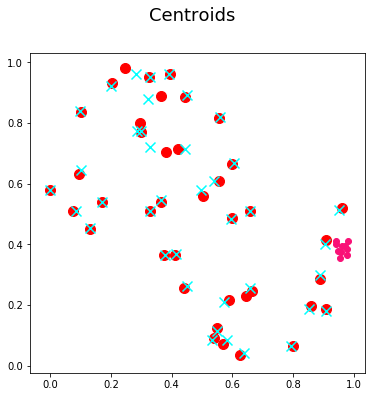

In [14]:
# Plot centroids
%matplotlib inline

c_id=0

plt.figure(5, figsize=(6,6))
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    if k == c_id:
        plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
plt.scatter([d[0] for d in drasiw], [d[1] for d in drasiw], marker="o", s=100, color="red")
plt.scatter([centroid[0] for centroid in centroids], [centroid[1] for centroid in centroids], marker="x", s=100, color="cyan")
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('Centroids', fontsize=18)
plt.show()

In [15]:
# Plot discriminator epsilon areas
def plot_epsilon_areas(discr_ids):
    # Plotting
    step = 0.01
    points = []

    for i in np.arange(0, 1, step):
        for j in np.arange(0, 1, step):
            discr = max([(id_, c_online.discriminators[id_].matching(
                c_online.addressing((i, j)))) for id_ in discr_ids], key=lambda x: x[1])
            c = color_dict[discr[0]]
            if discr[1] > c_online.epsilon:
                points.append(((i, j), c))
    plt.scatter([point[0][0] for point in points],
                          [point[0][1] for point in points],
                          marker="s",
                          s=1.5,
                          c=[point[1] for point in points])
    plt.axis('scaled', xlim=[0, 1, 0, 1])
    plt.show()

In [16]:
plot_epsilon_areas([0,1,2])

KeyboardInterrupt: 

Found 39 Microclusters and formed 2, 14, 2 Clusters.


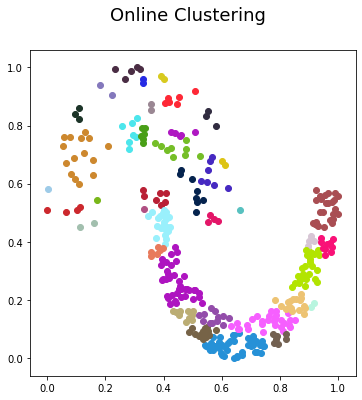

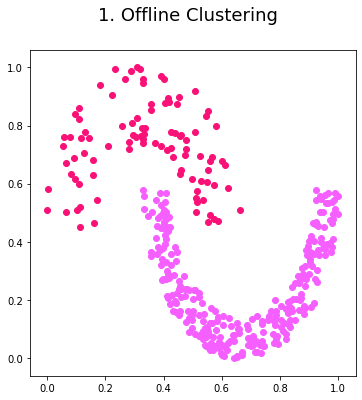

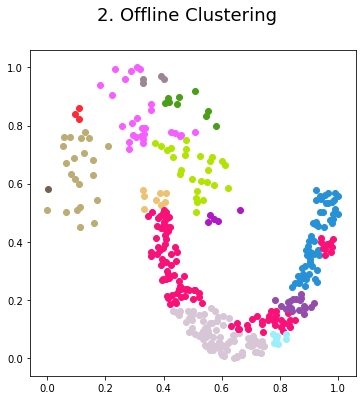

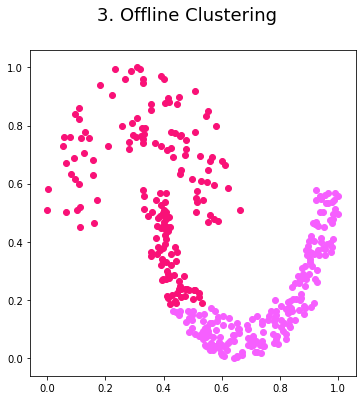

In [17]:
# Plot results of online vs offline clustering
%matplotlib inline

# Online
plt.figure(1, figsize=(6,6))
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
    plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('Online Clustering', fontsize=18)
    
# Offline1
plt.figure(2, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters1)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('1. Offline Clustering', fontsize=18)

# Offline2
plt.figure(3, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters2)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('2. Offline Clustering', fontsize=18)


# Offline3
plt.figure(4, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters3)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('3. Offline Clustering', fontsize=18)
    
print("Found {} Microclusters and formed {}, {}, {} Clusters.".format(len(c_online.discriminators), len(actual_clusters1), len(actual_clusters2), len(actual_clusters3)))
plt.show()

In [18]:
# Calculate Homogeneity, Completeness, V-Measure of clusterings
print("Homogeneity, Completeness, V-Measure")

# Online
print("Online: ", homogeneity_completeness_v_measure(datastream["Class"], assigned_discriminators))

# Offline
print("Offline1: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters1) for i in range(len(assigned_discriminators))]))
print("Offline2: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters2) for i in range(len(assigned_discriminators))]))
print("Offline3: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters3) for i in range(len(assigned_discriminators))]))

Homogeneity, Completeness, V-Measure
Online:  (0.9999999999999997, 0.1794954414759266, 0.3043597035887147)
Offline1:  (1.0, 1.0, 1.0)
Offline2:  (0.999999999999999, 0.27627467134146444, 0.432939205870282)
Offline3:  (0.44889439751514987, 0.37278525245675814, 0.40731497076708817)


The following cell visualizes the behavior of the online clustering over time. 

In [ ]:
# Live online clustering plot
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.ion()
ax.axis('scaled', xlim=[0, 1, 0, 1])
fig.show()
fig.canvas.draw()

for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    ax.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
    fig.canvas.draw()

## Data stream clustering

In [ ]:
# Plot class for every instance
%matplotlib notebook
plt.scatter(list(range(len(datastream["Class"])-100)), [np.mean(datastream["Class"][i:i+100]) for i in range(len(datastream["Class"])-100)])
plt.show()

## Results

| Data set | #Instances | Dimensions | Homogenity | Completeness | V-Measure | #Microclusters | Omega | Delta | Gamma | Beta | Epsilon | Mu | Runtime Online |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Complex8 | 2551 | 2 | 0.9053588976743742 | 0.9335710366851351 | 0.9192485574153881 | 91 | Inf | 200 | 200 | 70 | 0.1 | 0 | 24min 46s |
| Complex9 | 3031 | 2 | 0.9050691859653084 | 0.8300021530934564 | 0.8659117998655447 | 98 | Inf | 200 | 200 | 80 | 0.1 | 0 | 21min 22s |
| D31 | 3100 | 2 | 0.9055106871046765 | 0.9517232533653724 | 0.9280420288574567 | 44 | Inf | 200 | 200 | 30 | 0.3 | 0 | 5min 24s |
| Jain | 373 | 2 | 1.0 | 1.0 | 1.0 | 33 | Inf | 200 | 200 | 60 | 0.1 | 0 | 35.7 s |
| Aggregation | 788 | 2 | 0.9888391642302382 | 0.9876953626611313 | 0.9882669324921871 | 38 | Inf | 200 | 200 | 50 | 0.1 | 0 | 1min 43s |

Use Entropy, Purity/Homogenity and number of clusters for evaluation. Try different parameters until bes found and use them with different windows (3). Repeat each experiment 10 times.

Gamma: Resolution of binary encoding; unterteilt jede dimension in gamma subräume/abschnitte
Je höher, desto kleiner die epsilon area.

Delta: Bestimmt anzahl der Neuronen; Gibt an wie viele verschiedene Epsilonzonen es gibt (ohne 0%)
Je höher, desto größer die epsilon area.

Area gelichbeliben bei gelichem gamm delta verhältnis?!